# Language Learning

Combine learning Observation captioning and Contrastive Learning.

Load data:

In [4]:
import json

def load_pairs(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    pairs = []
    for step, s_data in data.items():
        if not step.startswith("Step"):
            continue
        pairs.append({
            "observation": s_data["Agent_0"]["Observation"],
            "sentence": s_data["Agent_0"]["Sentence"][1:-1]
        })
        pairs.append({
            "observation": s_data["Agent_1"]["Observation"],
            "sentence": s_data["Agent_1"]["Sentence"][1:-1]
        })
    return pairs

data_pairs = load_pairs("test_data/Sentences_Generated_P1.json")

train_data = data_pairs[:80000]
test_data = data_pairs[80000:]

Initialise models, loss and optimizer

In [5]:
import torch
from model.modules.lm import GRUEncoder, GRUDecoder, OneHotEncoder
from model.modules.obs import ObservationEncoder
from torch import nn, optim

def init_training_objects(voc, context_dim, obs_dim, lr):
    word_encoder = OneHotEncoder(voc)

    lang_enc = GRUEncoder(context_dim, word_encoder)
    dec = GRUDecoder(context_dim, word_encoder)

    obs_enc = ObservationEncoder(obs_dim, context_dim)

    cross_ent_l = nn.CrossEntropyLoss()
    nll_l = nn.NLLLoss()
    opt = optim.Adam(list(lang_enc.parameters()) + list(dec.parameters()) + list(obs_enc.parameters()), lr=lr)
    
    return word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt

Train

In [6]:
import time
import random
import numpy as np
from tqdm import tqdm

def sample_batch(data, batch_size):
    batch = random.sample(data, batch_size)
    obs_batch = []
    sent_batch = []
    for pair in batch:
        obs_batch.append(pair["observation"])
        sent_batch.append(pair["sentence"])
    return obs_batch, sent_batch

def sample_batch_nodup(data, batch_size):
    obs_batch = []
    sent_batch = []
    for b_i in range(batch_size):
        element = random.choice(data)
        obs = element["observation"]
        sent = element["sentence"]
        if sent in sent_batch:
            continue
        else:
            obs_batch.append(obs)
            sent_batch.append(sent)
    return obs_batch, sent_batch

def get_losses(obs_batch, sent_batch, obs_enc, lang_enc, dec, temp, cross_ent_loss, nll_loss):
    # Encode observations
    obs_tensor = torch.Tensor(np.array(obs_batch))
    context_batch = obs_enc(obs_tensor)

    # Encode sentence
    lang_context_batch = lang_enc(sent_batch)
    lang_context_batch = lang_context_batch.squeeze()

    # Compute similarity
    norm_context_batch = context_batch / context_batch.norm(dim=1, keepdim=True)
    lang_context_batch = lang_context_batch / lang_context_batch.norm(dim=1, keepdim=True)
    sim = norm_context_batch @ lang_context_batch.t() * temp
    mean_sim = sim.diag().mean()

    # Compute loss
    labels = torch.arange(len(obs_batch))
    loss_o = cross_ent_loss(sim, labels)
    loss_l = cross_ent_loss(sim.t(), labels)
    clip_loss = (loss_o + loss_l) / 2
    
    # Decoding
    encoded_targets = word_encoder.encode_batch(sent_batch)
    decoder_outputs, _ = dec(context_batch.detach(), encoded_targets)

    # Compute loss
    dec_loss = 0
    for d_o, e_t in zip(decoder_outputs, encoded_targets):
        e_t = torch.argmax(e_t, dim=1)
        dec_loss += nll_loss(d_o, e_t)
    
    return clip_loss, dec_loss, mean_sim

def train(data, obs_enc, lang_enc, dec, word_encoder, cross_ent_loss, nll_loss, opt, 
          n_iters=80000, batch_size=128, temp=0.07, eval_data=None, eval_evry=1000,
          sample_fn=sample_batch, clip_weight=1.0, capt_weight=1.0):
    start = time.time()
    
    clip_train_losses = []
    clip_eval_losses = []
    dec_train_losses = []
    dec_eval_losses = []
    eval_sims = []
    
    for s_i in tqdm(range(n_iters)):
        opt.zero_grad()
        
        # Sample batch
        obs_batch, sent_batch = sample_fn(data, batch_size)
        
        # Compute both losses
        clip_loss, dec_loss, _ = get_losses(obs_batch, sent_batch, obs_enc, lang_enc, dec, temp, 
                                         cross_ent_loss, nll_loss)
        
        # Backprop
        tot_loss = clip_weight * clip_loss + capt_weight * dec_loss
        tot_loss.backward()
        opt.step()
        
        clip_train_losses.append(clip_loss.item())
        dec_train_losses.append(dec_loss.item() / batch_size)
        
        if eval_data is not None and (s_i + 1) % eval_evry == 0:
            with torch.no_grad():
                # Sample batch
                obs_batch, sent_batch = sample_fn(eval_data, batch_size)
                
                # Get both losses
                clip_loss, dec_loss, sim = get_losses(
                    obs_batch, sent_batch, obs_enc, lang_enc, dec, temp, cross_ent_loss, nll_loss)
                clip_eval_losses.append(clip_loss.item())
                dec_eval_losses.append(dec_loss.item() / batch_size)
                eval_sims.append(sim)
    
    return clip_train_losses, clip_eval_losses, dec_train_losses, dec_eval_losses, eval_sims

Plot

In [7]:
import matplotlib.pyplot as plt

def plot_curves(curves, titles):
    """
    Inputs:
        curves (list(list(list(float)))): list of list of training curves, each element i of the main list is a list
            of all the training curves to plot in the subplot i.
    """
    nb_subplots = len(curves)
    
    fig, axs = plt.subplots(1, nb_subplots, figsize=(15,6))
    if type(axs) is not np.ndarray:
        axs = [axs]
    for ax, plot, title in zip(axs, curves, titles):
        max_len = max([len(c) for c in plot])
        for c in plot:
            c_len = len(c)
            if c_len == max_len:
                ax.plot(c)
            else:
                inter = max_len / c_len
                ax.plot((np.arange(c_len) + 1) * inter, c)
        ax.set_title(title)

100%|██████████████████████████████████████████████████████████████| 10000/10000 [06:20<00:00, 26.29it/s]


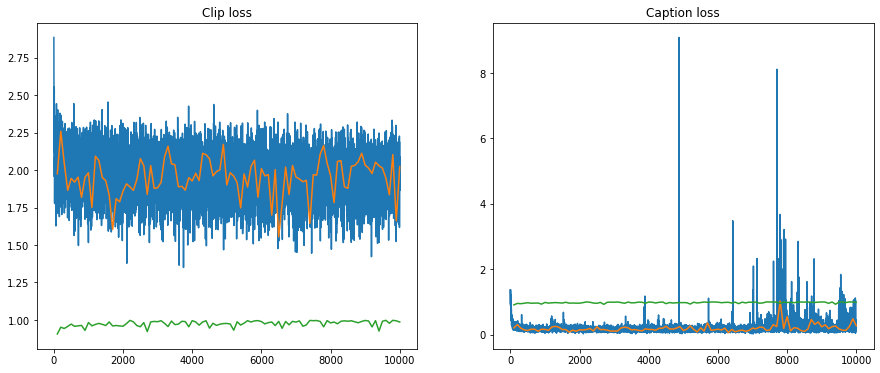

In [8]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    32, 17, 0.01)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=32,
    eval_data=test_data, temp=1.0, n_iters=10000, sample_fn=sample_batch_nodup, eval_evry=100)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

Smaller temperature

100%|██████████████████████████████████████████████████████████████| 10000/10000 [06:49<00:00, 24.45it/s]


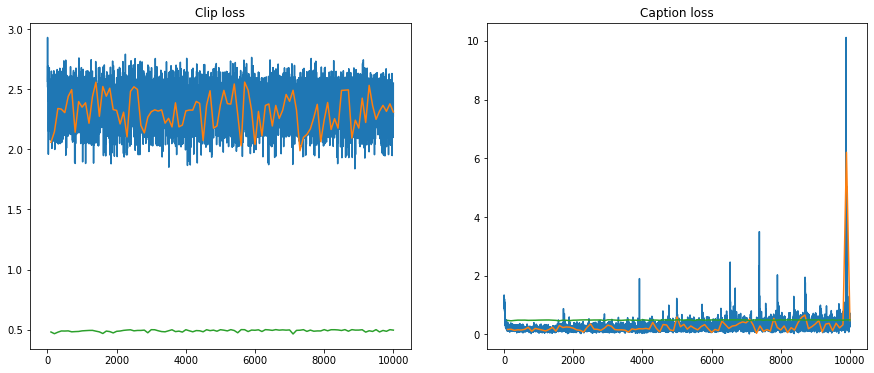

In [10]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    32, 17, 0.01)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=32,
    eval_data=test_data, temp=0.5, n_iters=10000, sample_fn=sample_batch_nodup, eval_evry=100)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

Smaller learning rate

100%|██████████████████████████████████████████████████████████████| 10000/10000 [06:58<00:00, 23.88it/s]


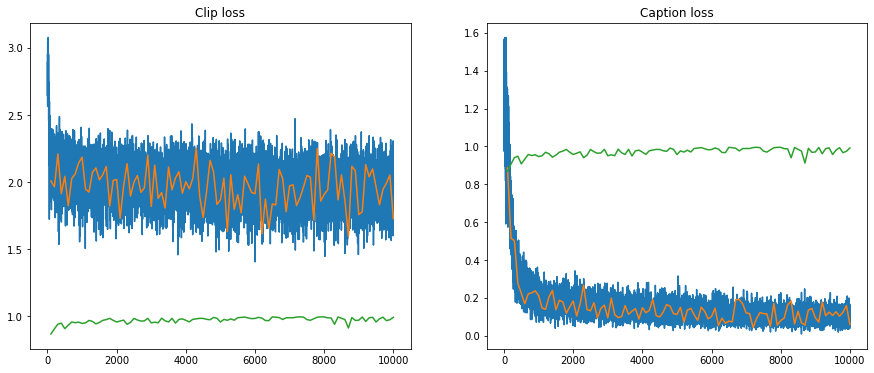

In [12]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    32, 17, 0.001)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=32,
    eval_data=test_data, temp=1.0, n_iters=10000, sample_fn=sample_batch_nodup, eval_evry=100)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

100%|██████████████████████████████████████████████████████████████| 10000/10000 [06:57<00:00, 23.93it/s]


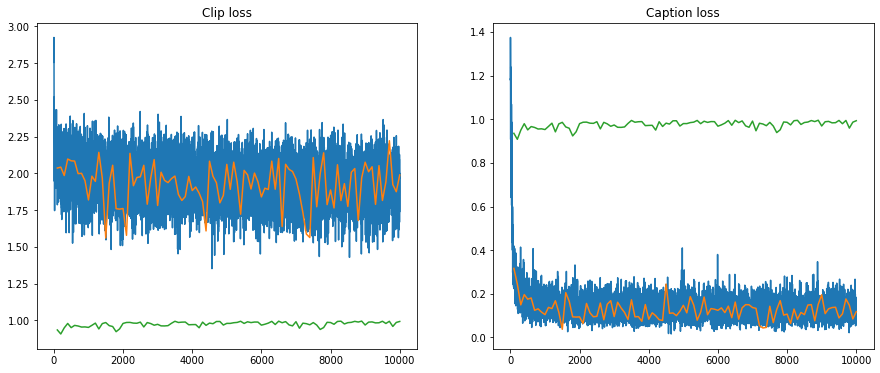

In [14]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    32, 17, 0.005)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=32,
    eval_data=test_data, temp=1.0, n_iters=10000, sample_fn=sample_batch_nodup, eval_evry=100)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

100%|██████████████████████████████████████████████████████████████| 10000/10000 [06:53<00:00, 24.20it/s]


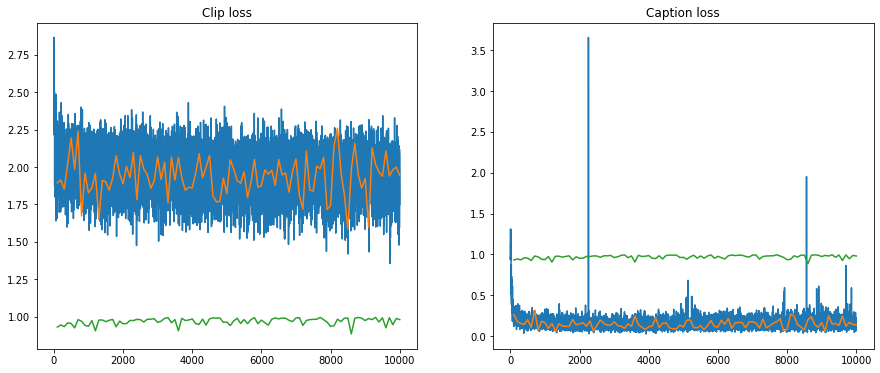

In [16]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    32, 17, 0.008)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=32,
    eval_data=test_data, temp=1.0, n_iters=10000, sample_fn=sample_batch_nodup, eval_evry=100)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

### Testing observation captioning

In [15]:
s = test_data[9]
s_enc = obs_enc(torch.Tensor([s["observation"]]))
_, s_pred = dec(s_enc)
print(s["sentence"])
word_encoder.decode_batch(s_pred)

['Located', 'South', 'West', 'Landmark', 'North', 'East']


[['Located', 'South', 'West', 'Landmark', 'North', 'East']]